# WarmStartQAOA-Epsilon

In [4]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

import numpy as np
import pandas as pd
import qiskit
provider = qiskit.IBMQ.load_account()

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, GoemansWilliamsonOptimizer
from qiskit_optimization.algorithms import RecursiveMinimumEigenOptimizer, IntermediateResult
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

ibmqfactory.load_account:WARNING:2021-09-13 10:03:32,268: Credentials are already in use. The existing account in the session will be replaced.


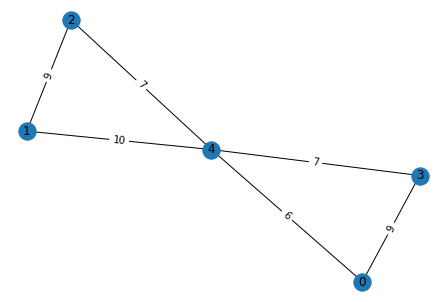

In [5]:
# ---- Define graph and MaxCut ----

graph = generate_butterfly_graph(with_weights=True)
opt_max_cut = -35
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

## Simulator

In [8]:
quantum_instance = QuantumInstance(
                                    backend=Aer.get_backend('qasm_simulator'),
                                    shots=1024
                                    )

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_optimization.algorithms import WarmStartQAOAFactory, MinimumEigenOptimizer
import numpy as np
from qiskit.circuit import (
    Parameter,
    ParameterVector,
    QuantumRegister,
    QuantumCircuit,
    ParameterExpression,
)

In [10]:
class MyWarmStartQAOAFactory(WarmStartQAOAFactory):
    def create_mixer(self, initial_variables: List[float]) -> QuantumCircuit:
        """
        Creates an evolved mixer circuit as Ry(theta)Rz(-2beta)Ry(-theta).
        Args:
            initial_variables: Already created initial variables.
        Returns:
            A quantum circuit to be used as a mixer in QAOA.
        """
        circuit = QuantumCircuit(len(initial_variables))
        beta = Parameter("beta")

        # here is the problem!! 
        # Beta ist als "globaler" Parameter einmal gesetzt. 
        # beta = initial_point[0]
        
        for index, relaxed_value in enumerate(initial_variables):
            theta = 2 * np.arcsin(np.sqrt(relaxed_value))
            
            circuit.ry(theta, index)
            circuit.rz(-2*beta, index)
            circuit.ry(-theta, index)

        return circuit


In [16]:
qaoa = QAOA(optimizer = COBYLA(maxiter=1),
            quantum_instance = quantum_instance,
            
            # reps = 2 -> initial_point = [beta1, beta2, gamma1, gamma2]
            # but not with WarmStart! 
            initial_point=[np.pi/2, 0., 1., 1.],
            reps=2,
            )
    
epsilon = 0.25
ws_factory = MyWarmStartQAOAFactory(epsilon)
ws_qaoa = WarmStartQAOAOptimizer(pre_solver=GoemansWilliamsonOptimizer(1),
                                 relax_for_pre_solver=False, qaoa=qaoa,
                                 num_initial_solutions=1, epsilon=epsilon,
                                 warm_start_factory=ws_factory,
                                )

    
result = ws_qaoa.solve(max_cut.to_qubo())

ValueError: The dimension of the initial point (4) does not match the number of parameters in the circuit (3).

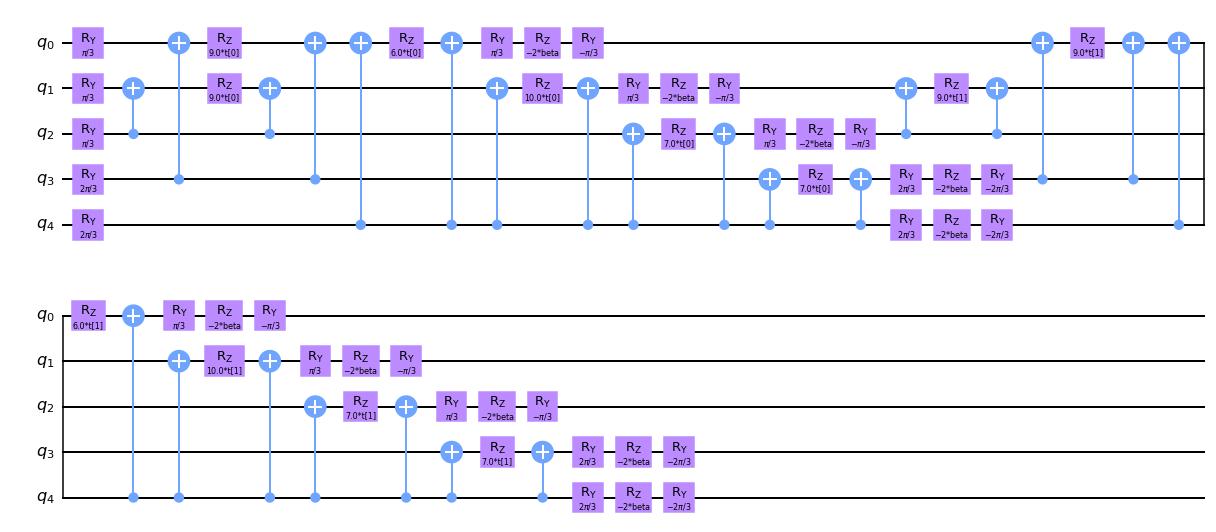

In [18]:
_=qaoa.ansatz.draw('mpl')